In [1]:
%matplotlib inline

#%matplotlib 
#import matplotlib.pyplot as plt
#plt.ion()

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style('darkgrid')
import scipy
from scipy import special as s
from scipy.optimize import minimize
import pandas as pd
import numpy
import math
from time import time

from mpl_toolkits.mplot3d import Axes3D

In [4]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [5]:
from utils.plot import *
from utils.tools import *
from utils.nn import TARGET_FUNCS_DICT, LOSS_DICT
from networks import linear_net

## Constants

In [6]:
n_samples = 100 # 500
input_dim = 60 # 50
width = 1024  # 1024
bias = False
base_lr = 1.0e-2
batch_size = 512

SEED = 42
n_steps = 3*int(1e3) # 5*int(1e4) # int(5e3) # 20000
n_trials = 5

#widths = [10, 20, 50, 128, 256, 1024]
# widths = [10, 50, 128, 1024]
widths = [1024]

In [7]:
FIGURES_DIR = os.path.join(ROOT, 'figures/2-layer/linear-net/')
create_dir(FIGURES_DIR)

In [8]:
set_random_seeds(SEED)

## Model

$\mathbb{P}$ is the empirical distribution $\mathbb{P} = \frac{1}{n} \sum_{i=1}^n \delta_{x_i}$, where $x_i \sim \mathcal{U}([-1, 1]^d)  =: P_x$.

 \begin{align*}
    f^*(x) &= C_d \sum_{k=1}^d z^\star_k x_k^3 \\
    z^\star &\sim \mathcal{U}(\mathbb{S}^{d-1}) \\
    C_d :&= \sqrt{7}
\end{align*}
with $C_d$ calibrated such that $\frac{1}{2}\mathbb{E}_{P_x}[f^*(x)^2] = 1$. 

Because $n=100 > 60=d$, and the $x_i$ are drawn uniformly, $X = [x_1; \ldots; x_n]^\top$ is full-rank and the least square problem $Q$ has a unique minimizer.

## Data & Net

In [9]:
# val & train data
X_val = 2 * torch.rand(size=(n_samples, input_dim), requires_grad=False) - 1
X_train = 2 * torch.rand(size=(n_samples, input_dim), requires_grad=False) - 1

z_star_gauss = torch.randn(size=(input_dim, 1), requires_grad=False)
z_star = z_star_gauss / torch.linalg.norm(z_star_gauss, ord=2, keepdims=False)

# C_d
#norm_z_star = torch.linalg.norm(z_star, ord=2, keepdims=False)
#C = np.sqrt((input_dim**3) * 2 / 15) / norm_z_star
C = np.sqrt(7)

#y_val = torch.sinh(torch.matmul(X_val, w_star) / np.sqrt(input_dim))
#all_ys = torch.sinh(torch.matmul(all_Xs, w_star)  / np.sqrt(input_dim))
y_val = C * torch.matmul(X_val**3, z_star)
y_train = C * torch.matmul(X_train**3, z_star)

w_star = torch.linalg.lstsq(input=X_train, b=y_train).solution
global_min = (torch.linalg.norm(y_train - torch.matmul(X_train, w_star), ord=2, keepdims=False)**2).item() /\
             (2*n_samples)

lambda_min = torch.min(torch.real(torch.linalg.eigvals(np.matmul(X_train.t(), X_train)))).item()

#w_star = (np.sqrt(6 * input_dim / 5) * z_star / norm_z_star).detach().numpy().reshape(-1)
#norm_w_star = np.linalg.norm(w_star)
#w_star_normalized = w_star / norm_w_star

In [10]:
lambda_min = torch.min(torch.real(torch.linalg.eigvals(np.matmul(X_train.t(), X_train)))).item()
lambda_min

2.0666303634643555

In [11]:
torch.sum(X_train**2)/n_samples

tensor(20.0014)

In [12]:
torch.sum(y_train**2)/n_samples

tensor(0.8923)

In [13]:
networks = {i: {width: linear_net.LinearNet(input_dim=input_dim, width=width, bias=bias) 
                for width in widths}
            for i in range(n_trials)}
for dic in networks.values():
    for network in dic.values():
        network.train()
optimizers = {i: {width: torch.optim.SGD(networks[i][width].parameters(), lr=width * base_lr) 
                  for width in widths}
              for i in range(n_trials)}

## Training dynamics

In [14]:
def train(network, optimizer):
    train_losses = []
    val_losses = []
    y_hat_vals = []
    ws = [np.zeros(input_dim)]
    with torch.no_grad():
        as_squared = [np.mean(network.output_layer.weight.detach().numpy().reshape(-1) **2 )] 

    for i in range(n_steps):
        optimizer.zero_grad()

        # forward
        y_hat = network.forward(X_train)
        loss_ = 0.5 * ((y_hat - y_train) ** 2).mean()

        # backward and gradient step
        loss_.backward()
        optimizer.step()
        train_losses.append(loss_.detach().item())

        # val
        with torch.no_grad():
            y_hat_val = network.forward(X_val)
            val_loss = 0.5 * ((y_hat_val - y_val) ** 2).mean()
            val_losses.append(val_loss.detach().item())
            y_hat_vals.append(y_hat_val.detach().numpy())

            ws_m = 0.5 * network.input_layer.weight.detach() * \
                         torch.transpose(network.output_layer.weight.detach(), 0, 1)
            ws.append(np.mean(ws_m.numpy(), axis=0))
            
            as_squared.append(np.mean(network.output_layer.weight.detach().numpy().reshape(-1) **2 ))
            

    train_losses = np.array(train_losses)
    val_losses = np.array(val_losses)
    y_hat_vals = np.array(y_hat_vals)
    ws = np.array(ws)
    as_squared = np.array(as_squared)

    #norm_ws = np.linalg.norm(ws, ord=2, axis=1, keepdims=True)
    #ws_normalized = ws[1:, :] / norm_ws[1:, :]
    
    return {'train_losses': train_losses,
            'val_losses': val_losses, 
            'y_hat_vals': y_hat_vals,
            'ws': ws,
            'as_squared': as_squared}
            #'ws_normalized': ws_normalized}

In [15]:
start = time()
training_results = {i: dict() for i in range(n_trials)}
for i in range(n_trials):
    for width in widths:
        training_results[i][width] = train(networks[i][width], optimizers[i][width])
end = time()

#ws = training_results[width]['ws']
print('Run time : {:.2f} minutes'.format((end - start) / 60))

Run time : 0.43 minutes


In [15]:
start = time()
training_results = dict()
for width in widths:
    training_results[width] = train(networks[width], optimizers[width])
end = time()

ws = training_results[width]['ws']
print('Run time : {:.2f} minutes'.format((end - start) / 60))

Run time : 1.45 minutes


## Plots

In [18]:
data_frames = []
for i in range(n_trials):
    for width in widths:
        data_ = pd.DataFrame(columns=['trial', 'width', '$t$', 'training_loss'])
        data_['training_loss'] = training_results[i][width]['train_losses']
        data_['trial'] = i
        data_['width'] = width
        data_['$t$'] = np.arange(len(training_results[i][width]['train_losses']))
        
        data_frames.append(data_)

In [26]:
data = pd.concat(data_frames, axis=0, ignore_index=True)
data.iloc[2998:3003, :]

,trial,width,$t$,training_loss
2998,0,1024,2998,0.027622
2999,0,1024,2999,0.027622
3000,1,1024,0,0.445838
3001,1,1024,1,0.441653
3002,1,1024,2,0.437523


In [ ]:
plt.figure(figsize=(12, 6))
#plt.ylim(-1, 4)

g = sns.lineplot(x='$t$', y="training_loss", hue='width', data=data)

#fig_path = os.path.join(fig_dir, '{}_output.png'.format(MODEL_NAME))
#plt.savefig(fig_path, bbox_inches='tight', pad_inches=0)
plt.show()

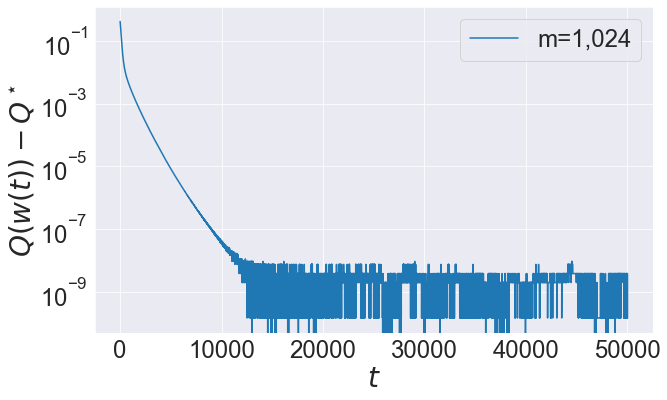

In [16]:
figure = plt.figure(figsize=(10, 6))

#plt.plot(np.arange(n_steps), np.exp(-lambda_min * base_lr * np.arange(n_steps) / 4), 
#         label='upper bound', color='black', linestyle='dashed', linewidth=1.5)   
#plt.plot(np.arange(n_steps), [global_min]*n_steps, label='global minimum', color='darkgrey', linestyle='dashed', 
#         linewidth=2.5)

for width in widths:
    plt.plot(np.arange(n_steps), training_results[width]['train_losses'] - global_min,
             label='m={:,}'.format(width))
         
plt.yscale('log')
#plt.yticks(ticks=[1e-2, 1e-1, 1], labels=['$10^{-2}$', '$10^{-1}$', '$1.0$'])
#plt.title('Train loss vs steps')
plt.xlabel('$t$', fontsize=28)
plt.ylabel('$Q(w(t)) - Q^\star$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, 'val_losses'), bbox_inches='tight')
plt.show()

In [44]:
w_star.detach().numpy().shape

(60, 1)

In [47]:
ws[:5, :] - w_star.detach().t().numpy()

array([[ 0.25203142,  0.15251301,  0.34137282,  0.17227657,  0.03337654,
        -0.01984188,  0.42034277,  0.21523117, -0.3211666 , -0.08826227,
        -0.04563823,  0.03245791, -0.12821002, -0.04107002,  0.32707441,
         0.3768177 ,  0.09462684, -0.00836789,  0.36160824, -0.15638724,
         0.18935597, -0.10243777, -0.09738585, -0.18850021,  0.02117028,
        -0.17553921, -0.01616672,  0.01427745, -0.08698502, -0.12981568,
        -0.07674596,  0.09753307, -0.30047053, -0.16178696, -0.18466793,
        -0.24038893, -0.07218728,  0.18394458,  0.54375893, -0.19278508,
        -0.06600017,  0.06841548,  0.13933951, -0.31005201,  0.40637338,
        -0.079051  , -0.06671685, -0.32958847,  0.28717443,  0.07973855,
         0.28464392,  0.04851128,  0.26880294, -0.3851313 , -0.16316259,
         0.14874312,  0.39900368,  0.02028468,  0.40997091, -0.05619374],
       [ 0.25311949,  0.1527614 ,  0.33758822,  0.17079985,  0.03196911,
        -0.01913831,  0.41910552,  0.21695535, -0.

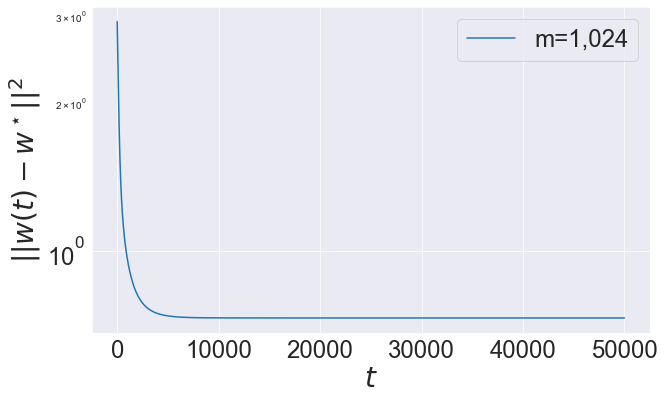

In [49]:
figure = plt.figure(figsize=(10, 6))

#plt.plot(np.arange(n_steps), np.exp(-lambda_min * base_lr * np.arange(n_steps) / 4), 
#         label='upper bound', color='black', linestyle='dashed', linewidth=1.5)   
#plt.plot(np.arange(n_steps), [global_min]*n_steps, label='global minimum', color='darkgrey', linestyle='dashed', 
#         linewidth=2.5)

for width in widths:
    plt.plot(np.arange(n_steps+1), np.sum((ws - w_star.detach().t().numpy())**2,  axis=1),
             label='m={:,}'.format(width))
         
plt.yscale('log')
#plt.yticks(ticks=[1e-2, 1e-1, 1], labels=['$10^{-2}$', '$10^{-1}$', '$1.0$'])
#plt.title('Train loss vs steps')
plt.xlabel('$t$', fontsize=28)
plt.ylabel('$||w(t) - w^\star||^2$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, 'val_losses'), bbox_inches='tight')
plt.show()

In [54]:
np.sum((ws - w_star.detach().t().numpy())**2, axis=1)[-1]

0.7318770205029002

In [23]:
w_final = ws[-1, :]
delta = np.abs(w_final - w_star.detach().numpy().reshape(-1))
np.argsort(delta)

array([17, 27, 26,  5, 57, 24, 11,  4, 13, 10, 51, 59, 40, 46, 41, 36, 30,
       45, 49, 28,  9, 16, 22, 31, 21, 12, 29, 42, 55,  1, 19, 33, 54,  3,
       25, 37, 34, 23, 20, 39,  7, 35,  0, 52, 50, 48, 32, 43,  8, 14, 47,
        2, 18, 15, 53, 56, 44, 58,  6, 38])

In [24]:
delta[[17, 27]]

array([0.00418369, 0.00713766])

In [29]:
# SIMPLE GD on Q

lin_w = torch.nn.Linear(in_features=input_dim, out_features=1, bias=False)
with torch.no_grad():
    lin_w.weight.data.copy_(torch.zeros_like(lin_w.weight))
opt = torch.optim.SGD(lin_w.parameters(), lr=base_lr)

lin_train_losses = []    
ws_lin = [np.zeros(input_dim)]

for i in range(n_steps):
    opt.zero_grad()

    # forward
    y_hat = lin_w.forward(X_train)
    loss_ = 0.5 * ((y_hat - y_train) ** 2).mean()

    # backward and gradient step
    loss_.backward()
    opt.step()
    lin_train_losses.append(loss_.detach().item())

    # val
    with torch.no_grad():
        ws_lin.append(lin_w.weight.detach().numpy().reshape(-1))


lin_train_losses = np.array(lin_train_losses)
ws_lin = np.array(ws_lin)

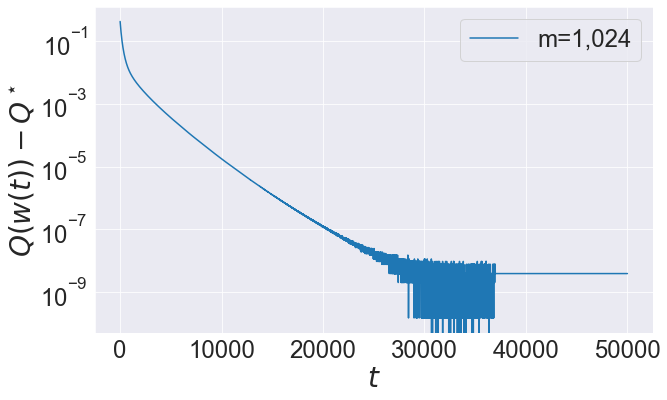

In [30]:
figure = plt.figure(figsize=(10, 6))

#plt.plot(np.arange(n_steps), np.exp(-lambda_min * base_lr * np.arange(n_steps) / 4), 
#         label='upper bound', color='black', linestyle='dashed', linewidth=1.5)   
#plt.plot(np.arange(n_steps), [global_min]*n_steps, label='global minimum', color='darkgrey', linestyle='dashed', 
#         linewidth=2.5)

for width in widths:
    plt.plot(np.arange(n_steps), lin_train_losses - global_min,
             label='m={:,}'.format(width))
         
plt.yscale('log')
#plt.yticks(ticks=[1e-2, 1e-1, 1], labels=['$10^{-2}$', '$10^{-1}$', '$1.0$'])
#plt.title('Train loss vs steps')
plt.xlabel('$t$', fontsize=28)
plt.ylabel('$Q(w(t)) - Q^\star$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, 'val_losses'), bbox_inches='tight')
plt.show()

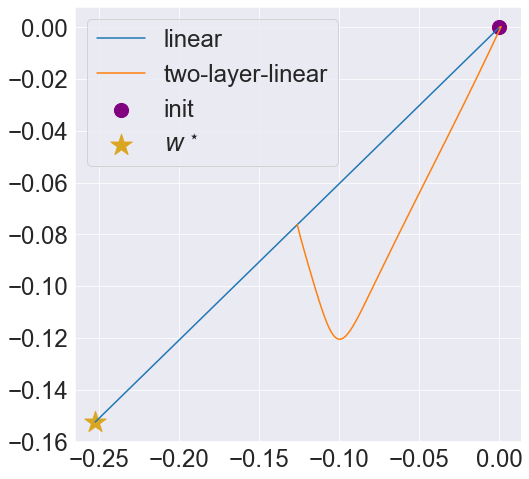

In [42]:
(k1, k2) = (0, 1)
w_star_np = w_star.detach().numpy()

figure = plt.figure(figsize=(8, 8))
plt.plot(ws_lin[:, k1], ws_lin[:, k2], linewidth=1.5, label='linear')
plt.plot(ws[:, k1], ws[:, k2], linewidth=1.5, label='two-layer-linear')
plt.scatter(ws[0, k1], ws[0, k2], marker='o', s=200, label='init', c='purple')
plt.scatter(w_star_np[k1], w_star_np[k2], marker='*', s=500, label='$w^\\star$', c='goldenrod')

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)

plt.show()

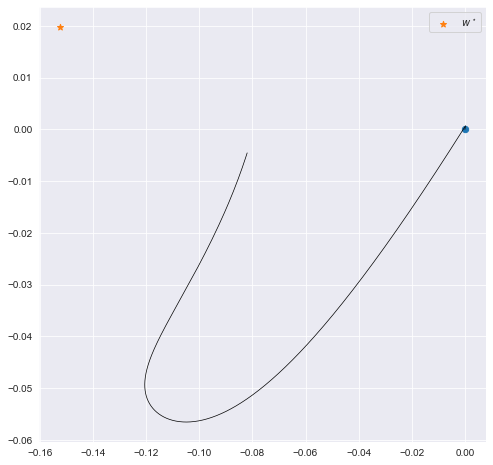

In [56]:
(k1, k2) = (1, 5)
figure = plt.figure(figsize=(8, 8))
plt.scatter(ws[0, k1], ws[0, k2], marker='o', s=40)
plt.plot(ws[:, k1], ws[:, k2], color='black', linewidth=0.7)
plt.scatter(w_star[k1], w_star[k2], marker='*', s=40, label='$w^\\star$')
plt.legend()
plt.show()

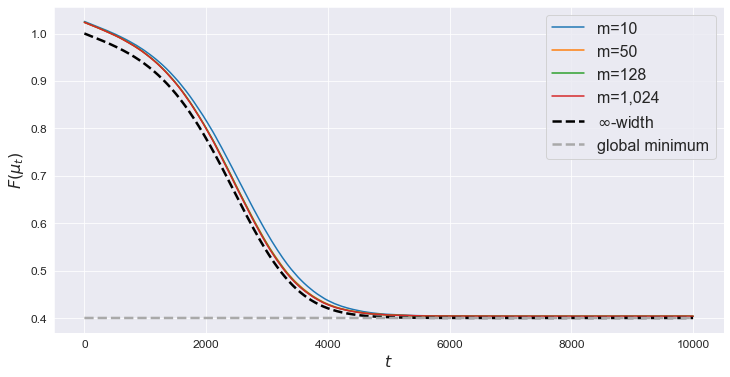

In [18]:
figure = plt.figure(figsize=(12, 6))

for width in widths:
    plt.plot(np.arange(len(training_results[width]['val_losses'])), training_results[width]['val_losses'],
             label='m={:,}'.format(width))

delta_lambdas = np.array(w_lambdas) - w_star.reshape(1, -1)
squared_norm_delta_lambdas = np.sum(delta_lambdas ** 2, axis=1)
# theoretical_losses = 0.5 * (1 - (norm_w_star**2) / input_dim + squared_norm_delta_lambdas / input_dim)
theoretical_losses = 0.5 * (2 + (squared_norm_delta_lambdas - norm_w_star**2) / input_dim)

#plt.plot(np.arange(len(delta_lambdas)), theoretical_losses, label='$\\infty$-width', color='k', 
#         linestyle='dashed', linewidth=2.5)

#plt.plot(np.arange(len(delta_lambdas)), [0.5*(2 - (norm_w_star**2) / input_dim )]*len(delta_lambdas), 
#         label='global minimum', color='darkgrey', linestyle='dashed', linewidth=2.5)

#plt.title('Validation loss', fontsize=16)
plt.xlabel('$t$', fontsize=16)
plt.ylabel('$F(\mu_t)$', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=16)
plt.savefig(os.path.join(FIGURES_DIR, 'val_losses'), bbox_inches='tight')
plt.show()

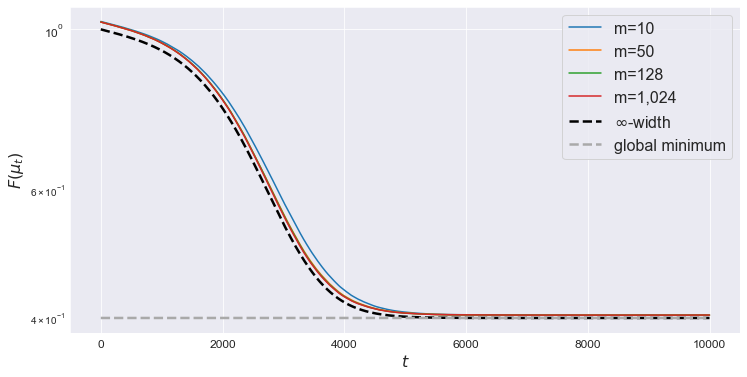

In [23]:
figure = plt.figure(figsize=(12, 6))

for width in widths:
    plt.plot(np.arange(len(training_results[width]['val_losses'])), training_results[width]['val_losses'],
             label='m={:,}'.format(width))

delta_lambdas = np.array(w_lambdas) - w_star.reshape(1, -1)
squared_norm_delta_lambdas = np.sum(delta_lambdas ** 2, axis=1)
# theoretical_losses = 0.5 * (1 - (norm_w_star**2) / input_dim + squared_norm_delta_lambdas / input_dim)
theoretical_losses = 0.5 * (2 + (squared_norm_delta_lambdas - norm_w_star**2) / input_dim)

plt.plot(np.arange(len(delta_lambdas)), theoretical_losses, label='$\\infty$-width', color='k', 
         linestyle='dashed', linewidth=2.5)

plt.plot(np.arange(len(delta_lambdas)), [0.5*(2 - (norm_w_star**2) / input_dim )]*len(delta_lambdas), 
         label='global minimum', color='darkgrey', linestyle='dashed', linewidth=2.5)

#plt.title('Validation loss', fontsize=16)
plt.yscale('log')
plt.xlabel('$t$', fontsize=16)
plt.ylabel('$F(\mu_t)$', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=16)
plt.savefig(os.path.join(FIGURES_DIR, 'val_losses'), bbox_inches='tight')
plt.show()

In [ ]:
figure = plt.figure(figsize=(12, 6))

for width in widths:
    plt.plot(np.arange(len(training_results[width]['val_losses'])), training_results[width]['val_losses'],
             label='m={:,}'.format(width))

delta_lambdas = np.array(w_lambdas) - w_star.reshape(1, -1)
squared_norm_delta_lambdas = np.sum(delta_lambdas ** 2, axis=1)
# theoretical_losses = 0.5 * (1 - (norm_w_star**2) / input_dim + squared_norm_delta_lambdas / input_dim)
theoretical_losses = 0.5 * (2 + (squared_norm_delta_lambdas - norm_w_star**2) / input_dim)

plt.plot(np.arange(len(delta_lambdas)), theoretical_losses, label='$\\infty$-width', color='k', 
         linestyle='dashed', linewidth=2.5)

plt.plot(np.arange(len(delta_lambdas)), [0.5*(2 - (norm_w_star**2) / input_dim )]*len(delta_lambdas), 
         label='global minimum', color='darkgrey', linestyle='dashed', linewidth=2.5)

#plt.title('Validation loss', fontsize=16)
plt.yscale('log')
plt.xlabel('$t$', fontsize=16)
plt.ylabel('$F(\mu_t)$', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=16)
plt.savefig(os.path.join(FIGURES_DIR, 'val_losses'), bbox_inches='tight')
plt.show()

In [19]:
with torch.no_grad():
    print(0.5 * torch.mean(y_val**2))

tensor(1.0234)


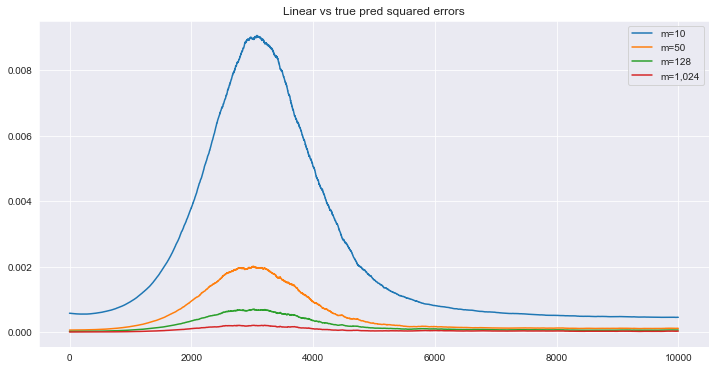

In [20]:
figure = plt.figure(figsize=(12, 6))
for width in widths:
    y_hat_vals = training_results[width]['y_hat_vals']
    ws = training_results[width]['ws'][1:, :]
    lin_preds = np.matmul(ws, np.transpose(X_val.detach().numpy()))
    
    deltas = lin_preds - y_hat_vals.reshape(y_hat_vals.shape[0], y_hat_vals.shape[1])
    errors = np.mean(deltas ** 2, axis=1)


    plt.plot(np.arange(len(errors)), errors, label='m={:,}'.format(width))
plt.title('Linear vs true pred squared errors')
plt.legend()
plt.show()

In [21]:
#figure = plt.figure(figsize=(12, 6))
#xs = np.arange(len(lambdas))
#plt.plot(xs, lambdas, label='$\\Lambda_k$')
#plt.title('$\\Lambda_k$ vs $k$')
#plt.legend()
#plt.show()

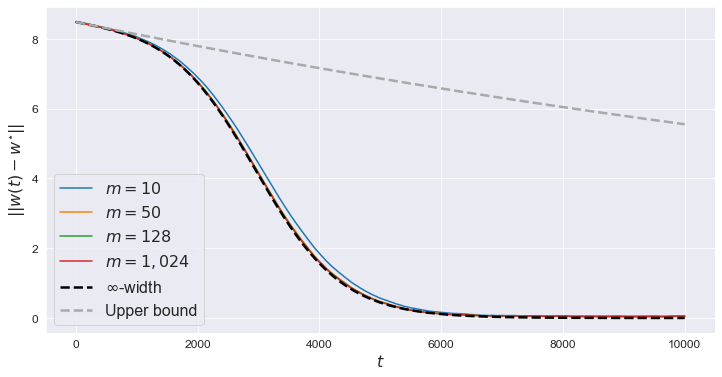

In [22]:
# CONVERGENCE of w(t) towards w_star
figure = plt.figure(figsize=(12, 6))
xs = np.arange(len(lambda_primes))
delta_lambdas = np.array(w_lambdas) - w_star.reshape(1, -1)

for width in widths:
    deltas = training_results[width]['ws'] - w_star.reshape(1, -1)
    plt.plot(np.arange(len(deltas)), np.sqrt(np.sum(deltas ** 2, axis=1)), label='$m={:,}$'.format(width))

plt.plot(np.arange(len(delta_lambdas)), np.sqrt(np.sum(delta_lambdas ** 2, axis=1)), label='$\\infty$-width',
         color='k', linestyle='dashed', linewidth=2.5)
plt.plot(xs, norm_w_star * np.exp([- V / (4 * input_dim) * base_lr * k for k in xs]), label='Upper bound', 
         color='darkgrey', linestyle='dashed', linewidth=2.5)
#plt.title('$||w(t) - w^{\star}||$', fontsize=16)
plt.legend()
plt.xlabel('$t$', fontsize=16)
plt.ylabel('$||w(t) - w^{\star}||$', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=16)
plt.savefig(os.path.join(FIGURES_DIR, 'deltas'), bbox_inches='tight')
plt.show()

In [25]:
m = 1024
ws = training_results[m]['ws']

In [27]:
ws.shape

(10001, 60)

In [28]:
w_star

array([-0.24131739, -0.6662252 , -0.18208835,  0.2773863 ,  1.9223922 ,
       -2.6777115 , -1.1556462 ,  0.69137377,  0.38519844,  0.72805333,
        0.38551107,  0.85871166, -1.018919  , -0.07314134, -0.88445663,
        1.1962819 , -2.090595  ,  1.9921433 ,  1.2494636 ,  2.3139896 ,
       -1.0537952 ,  0.31051725, -0.5061933 ,  0.2513372 ,  0.28632113,
        1.5065589 ,  3.7709157 ,  0.5795386 ,  0.12772568, -0.53745055,
        0.1221059 ,  0.9075841 ,  0.13387136,  0.5219698 , -0.6492762 ,
        2.820242  ,  0.0506125 ,  0.9785365 ,  1.0833094 ,  0.3460013 ,
        0.07770695,  1.175865  ,  0.86917603, -0.21112755, -0.309964  ,
       -0.78075546, -0.26538393,  0.33568138,  0.31893647,  0.48673987,
       -0.06251819,  0.37978947, -0.490367  , -0.36917338,  0.661911  ,
        0.04577436,  0.00891092, -0.7177304 ,  1.3644623 , -1.1736777 ],
      dtype=float32)

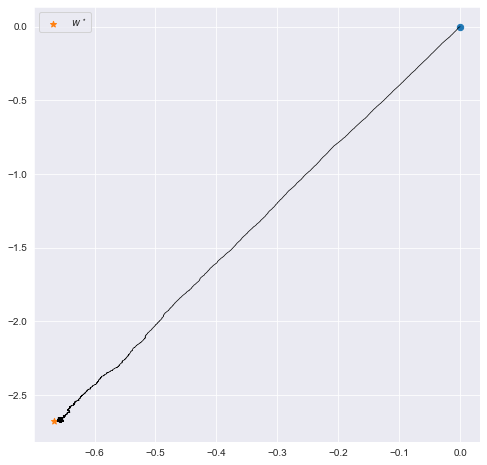

In [37]:
(k1, k2) = (1, 5)
figure = plt.figure(figsize=(8, 8))
plt.scatter(ws[0, k1], ws[0, k2], marker='o', s=40)
plt.plot(ws[:, k1], ws[:, k2], color='black', linewidth=0.7)
plt.scatter(w_star[k1], w_star[k2], marker='*', s=40, label='$w^\\star$')
plt.legend()
plt.show()